<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/1-RiskReturnModels.ipynb) -->

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://gitlab.com/pet_projects5572314/assist4edu/assist4edu/-/blob/main/notebooks/RAG_QA_prototype.ipynb) -->

Прототип

In [1]:
!pip install --upgrade langchain openai langchain_experimental langchain-openai tiktoken numexpr sentence-transformers faiss-cpu rank_bm25 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.4/262.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from getpass import getpass
import warnings
warnings.filterwarnings('ignore')
from typing import Literal
from langchain.schema.runnable import RunnableBranch, RunnablePassthrough, RunnableLambda
from langchain.output_parsers.openai_functions import PydanticAttrOutputFunctionsParser
from langchain.pydantic_v1 import BaseModel
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
import pandas as pd
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
)
from langchain.document_loaders import TextLoader, DirectoryLoader
from openai import OpenAI
from operator import itemgetter

In [29]:
from google.colab import userdata

# берем ключ из colab secrets
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_KEY')

# инициализируем языковую модель
llm = ChatOpenAI(temperature=0.0)

In [5]:
User_request = {"question":"Как работает версионирование в MLOps?"}

In [6]:
embeddings_api_model = OpenAIEmbeddings()

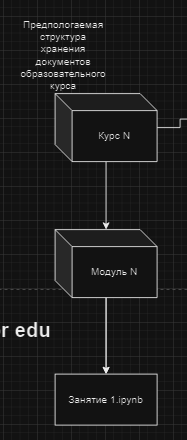

В датафрейм сохраним Названия курсов,их краткие описания, id курса, путь к директории курса

In [7]:
example_courses = [
    {
        'course_id':101001,
        'course_name':"MLOps и production в DS исследованиях 3.0",
        'course_description':'Современные подходы и инструменты для исследований на данных, разработки и внедрения ML-решений в production.',
        'course_destination': f"courses/101001_MLOps и production в DS исследованиях 3.0/"
    }
    ]
example_courses_df = pd.DataFrame(example_courses)
example_courses_df['course_full_info'] = example_courses_df['course_name'] + example_courses_df['course_description']
courses_loader = DataFrameLoader(example_courses_df, page_content_column='course_full_info')
courses_documents = courses_loader.load()

# Определяем сплиттер
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
courses_split_texts = splitter.split_documents(courses_documents)




In [27]:
example_courses_df

course_id                                course_name  \
0     101001  MLOps и production в DS исследованиях 3.0   

                                  course_description  \
0  Современные подходы и инструменты для исследов...   

                                  course_destination  \
0  courses/101001_MLOps и production в DS исследо...   

                                    course_full_info  
0  MLOps и production в DS исследованиях 3.0Совре...

In [9]:
type(courses_split_texts[0])

langchain_core.documents.base.Document

In [10]:
# Создаём векторное хранилище
courses_db = FAISS.from_documents(courses_split_texts, embeddings_api_model)

# Задаём ретривер
courses_retriever = courses_db.as_retriever()

In [11]:
def get_course_datum(inputs:dict) -> dict:
  text = inputs['question']
  relevant_course_data = courses_retriever.get_relevant_documents(text)[0]
  relevant_course_datum = relevant_course_data.metadata
  return {'question' : text, 'course_datum':relevant_course_datum}

Теперь определим поиск нужного занятия по курсу

In [12]:
try:
  os.makedirs("courses/101001_MLOps и production в DS исследованиях 3.0/Модуль 1")
except Exception:
  pass

In [13]:
with open('courses/101001_MLOps и production в DS исследованиях 3.0/Модуль 1/Занятие 1.txt', 'w', encoding='utf-16') as f:
  f.write("""Версионирование моделей
Так же, как и данные, модели машинного обучения нуждаются в версионировании для отслеживания изменений и обеспечения воспроизводимости.

MLflow: Этот инструмент позволяет не только версионировать модели, но и отслеживать эксперименты, параметры, метрики и результаты.

DVC: Как и для данных, DVC может использоваться для версионирования моделей, особенно когда модель тесно связана с данными.""")


In [14]:
def format_docs(inputs:dict) -> dict:
  docs = inputs['context']
  return {'question' : inputs['question'], 'course_datum':inputs['course_datum'], 'context':"\n\n".join([d.page_content for d in docs])}

Пока что затычка, вместе с курсами можно хранить и векторное хранилище для быстрого поиска, пока что функция создает FAISS каждый раз с нуля

In [15]:
def get_relevant_lessons(inputs:dict) -> dict:
  text = inputs['question']
  course_datum = inputs['course_datum']
  text_loader_kwargs={'autodetect_encoding': True}
  lessons_loader = DirectoryLoader(course_datum['course_destination'], glob="**/*.txt", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
  lessons_docs = lessons_loader.load()
  splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
  )
  lessons_split_texts = splitter.split_documents(lessons_docs)
  lessons_db = FAISS.from_documents(lessons_split_texts, embeddings_api_model)

  # Задаём ретривер
  lessons_retriever = lessons_db.as_retriever()
  relevant_lessons_data = lessons_retriever.get_relevant_documents(text)
  if len(relevant_lessons_data)>=3:
    return {'question' : text, 'course_datum':course_datum, 'context':relevant_lessons_data[:3]}
  return {'question' : text, 'course_datum':course_datum, 'context':relevant_lessons_data}

In [16]:
relevant_documents_chain = (
    {
        "context": {'question': itemgetter("question")} | RunnableLambda(get_course_datum) | RunnableLambda(get_relevant_lessons) | RunnableLambda(format_docs),
        "question": itemgetter('question'),
    }
)

Создаем первичную обработку запроса

In [17]:
moderator = OpenAI()
def moderate(inputs:dict) -> dict:
  text = inputs['question']
  response = moderator.moderations.create(input=text)
  output = response.results[0].flagged
  if output:
    raise Exception
  else:
    return {'question':text}

In [18]:
class TypeClassifier(BaseModel):
    "Определи вид запроса"

    topic: Literal["вопрос по курсу", "general"]
    "Вид запроса, либо это вопрос связанный с образовательным курсом, либо general, то есть все остальное. Если вопрос связан с каким нибудь техническим знанием то это вопрос по курсу. Если же вопрос на общую тему, например о настроении или о погоде, то это general"

In [19]:
classifier_function = convert_pydantic_to_openai_function(TypeClassifier)

model = ChatOpenAI().bind(
    functions=[classifier_function],
    function_call={"name": "TypeClassifier"}
)
parser = PydanticAttrOutputFunctionsParser(pydantic_schema=TypeClassifier, attr_name="request_type")

classifier_chain = model | parser

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [20]:
course_helper_prompt_template = """Ты - личный куратор студента.
Твоя задача на основе контекста образовательного курса ответить на вопрос студента,
используй контекст

{context}


Вот вопрос студента:
{question}"""
general_helper_prompt_template = """Ты - личный куратор студента.
Ты должен помочь студенту с его вопросом или задачей.
Вот вопрос студента:

{question}
"""

In [21]:
from langchain_core.prompts import PromptTemplate

In [22]:
course_helper_prompt = PromptTemplate.from_template(course_helper_prompt_template)
general_helper_prompt = PromptTemplate.from_template(general_helper_prompt_template)

In [23]:
branch = RunnableBranch(
    (lambda x: x["topic"] == "вопрос по курсу", relevant_documents_chain | course_helper_prompt),
    general_helper_prompt
)

In [24]:
from langchain_core.output_parsers import StrOutputParser

In [25]:
router_chain = (
    moderate
    | RunnablePassthrough.assign(topic=itemgetter("question") | classifier_chain)
    | branch
    | llm
    | StrOutputParser()
)

In [26]:
router_chain.invoke(User_request)

AttributeError: 'TypeClassifier' object has no attribute 'request_type'